In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
import statistics

# Краткое описание работы

### Данный проект представляет собой решение задачи классификации пассажиров Титаника на выживших и нет - целевой признак Survived (0 - no, 1 - yes). 

### Ноутбук состоит из двух частей: в первой происходит анализ и визуализация данных, во второй демонстрация результатов и отчет о проделанной работе.

##### В первой части:
* я нашла пропуски и разобралась с ними
* поняла, что есть выбросы в некоторых категориях
* увидела, какие признаки потребуют масштабирования (scaling)
* перевела признаки в категориальные и визуализировала с помощью гистограмм, чтобы понять общую ситуацию
* провела анализ выживших (целевой признак Survived) и построила графики, на которых увидели, какой процент каждой категории людей выживал относительно общей массы и относительно своей категории
* поняла, какую подготовку данных необходимо провести перед началом классификации

##### Во второй части:
* я представила классификаторы, которые будут использованы в работе
* показала гиперпараметры каждого и кратко описала процесс их поиска на валидационной части тренировочной выборки
* привела сравнение всех классификаторов, а также их ансамблей с различными видами голосования на тестовой части тренировочной выборки с помощью нескольких метрик
* визуализировала результаты для тренировочной выборки 
* представила результат на тестовой выборке (для этого отправила предсказание на кагл и получила результат их метрики)
* сформировала краткий отчет о применяемых моделях

# Часть 1: анализ и визуализация данных

## Представление данных

In [31]:
dirname = os.path.abspath('')
filename_train = os.path.join(dirname, r'.\data\train.csv')
df = pd.read_csv(filename_train)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Классифицируем признаки: 
* Survived, Name, Sex, Ticket, Cabin, Embarked (Port of Embarkation) - категориальные; 
* Pclass - порядковый (как количество звездочек у отеля); 
* Age, SibSp (Siblings/Spouses Aboard), Parch (number of parents / children aboard), Fare - количественные.

## Анализ данных на пропуски, дубликаты

In [10]:
print(f'Стоблцы с пропусками: {df.columns[df.isnull().any()].tolist()}')
df.isnull().sum()

Стоблцы с пропусками: ['Age', 'Cabin', 'Embarked']


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [12]:
df[df.duplicated()] # дубликатов нет

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


Как мы видим, в данных присутствуют:
* nans в фичах Age (177), Cabin (687), Embarked (2);

В предобработке данных это учтено и исправлено. Для достоверности дальнейшего анализа заменим nans в Age на среднее значение фичи, а колонки Cabin и Embarked в исследовании учитываться не будут.

In [32]:
df["Age"].fillna(df["Age"].mean(),inplace= True)
df.drop(['Embarked', 'Cabin'], axis=1, inplace=True)

## Визуализация и систематизация данных

In [57]:
n_of_men = df[df['Sex'] == 'male'].shape[0]
n_of_women = df[df['Sex'] == 'female'].shape[0]
n_of_1_class = df[df['Pclass'] == 1].shape[0]
n_of_2_class = df[df['Pclass'] == 2].shape[0]
n_of_3_class = df[df['Pclass'] == 3].shape[0]
min_age = int(df.Age.min())
max_age = int(df.Age.max())
mean_age = round(df.Age.mean(), 3)
survived = df[df['Survived'] == 1].shape[0]
unsurvived = df[df['Survived'] == 0].shape[0]

print(f"На Титанике было {n_of_men} мужчин и {n_of_women} женщин. \n" 
      f"{n_of_1_class} пассажиров являлись пассажирами 1ого класса, {n_of_2_class} - 2ого класса и {n_of_3_class} - 3-его класса. \n"
      f"Средний возраст пассажиров - {mean_age}, примерный диапазон: {min_age} - {max_age} лет. \n"
      f"Статистика выживаемости следующая: {survived} пассажиров выжило, {unsurvived}, к сожалению, нет.")

На Титанике было 577 мужчин и 314 женщин. 
216 пассажиров являлись пассажирами 1ого класса, 184 - 2ого класса и 491 - 3-его класса. 
Средний возраст пассажиров - 29.699, примерный диапозон: 0 - 80 лет. 
Статистика выживаемости следующая: 342 пассажиров выжило, 549, к сожалению, нет.


Посмотрим на данные с помощью гистограмм.

Text(0.5, 1.0, 'SibSp hist')

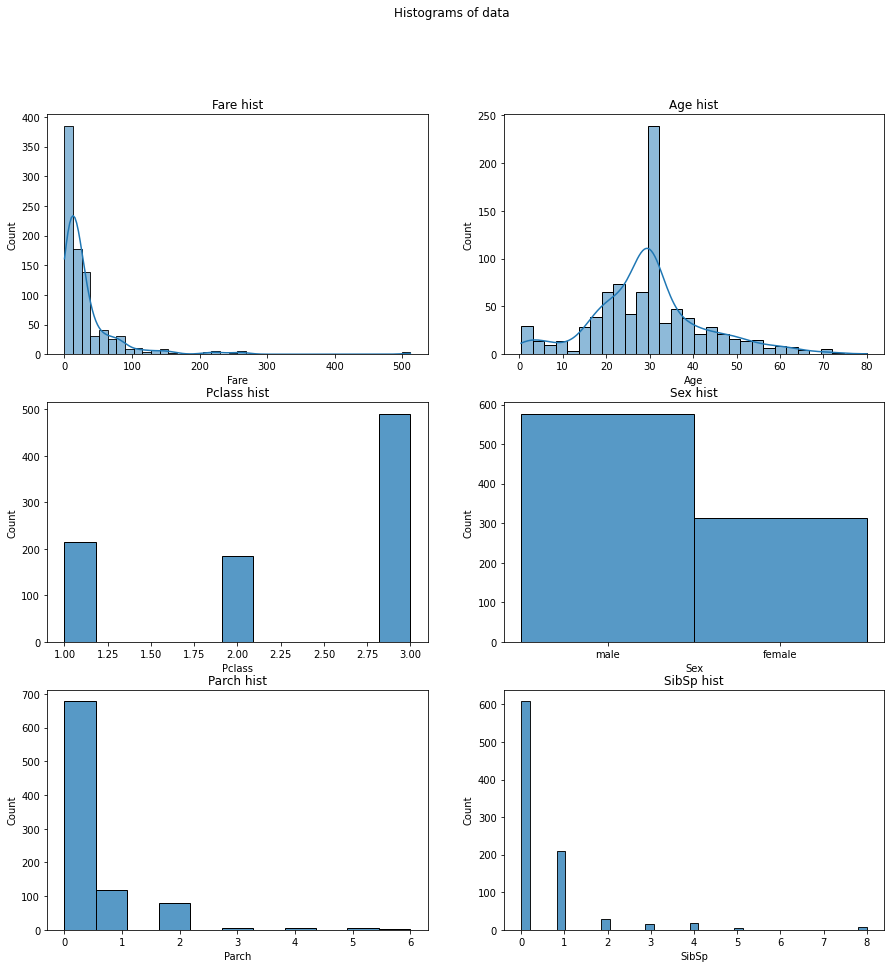

In [50]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Histograms of data')

sns.histplot(ax=axes[0][0], data=df, x="Fare", kde=True, bins=40)
axes[0][0].set_title("Fare hist")

sns.histplot(ax=axes[0][1], data=df, x="Age", kde=True)
axes[0][1].set_title("Age hist")

sns.histplot(ax=axes[1][0], data=df, x="Pclass")
axes[1][0].set_title("Pclass hist")

sns.histplot(ax=axes[1][1], data=df, x="Sex")
axes[1][1].set_title("Sex hist")

sns.histplot(ax=axes[2][0], data=df, x="Parch")
axes[2][0].set_title("Parch hist")

sns.histplot(ax=axes[2][1], data=df, x="SibSp")
axes[2][1].set_title("SibSp hist")

Как мы видим, для некоторых фичей заметны выбросы и просто маловероятные значения, для дальнейшего анализа можно превратить часть количественных признаков в категориальные.

In [54]:
def convert_number_to_cat(df):
    """
    df: dataframe
    return: df with new columns for each converted feature
    """
    # fare
    df.loc[df.Fare <= 15, 'Fare_cat'] = 0
    df.loc[(15 < df.Fare) & (df.Fare <= 35), 'Fare_cat'] = 1
    df.loc[(35 < df.Fare) & (df.Fare <= 100), 'Fare_cat'] = 2
    df.loc[df.Fare > 100, 'Fare_cat'] = 3
    
    # age
    df.loc[df.Age < 25, 'Age_cat'] = 0
    df.loc[(25 <= df.Age) & (df.Age <= 50), 'Age_cat'] = 1
    df.loc[df.Age > 50, 'Age_cat'] = 2
    
    # parch
    df.loc[df.Parch == 0, 'Parch_cat'] = 0
    df.loc[(df.Parch == 1) | (df.Parch == 2), 'Parch_cat'] = 1
    df.loc[df.Parch >= 3, 'Parch_cat'] = 2
    
    # SibSp
    df.loc[df.SibSp == 0, 'SibSp_cat'] = 0
    df.loc[df.SibSp == 1, 'SibSp_cat'] = 1
    df.loc[df.SibSp >= 2, 'SibSp_cat'] = 2
    
    # Sex
    df.loc[df.Sex == 'female', 'Sex_cat'] = 0
    df.loc[df.Sex == 'male', 'Sex_cat'] = 1
    
    return df[['Survived', 'Fare_cat', 'Age_cat', 'Parch_cat', 'SibSp_cat', 'Pclass', 'Sex_cat']]

In [55]:
converted_df = convert_number_to_cat(df)
converted_df.head(10)

,Survived,Fare_cat,Age_cat,Parch_cat,SibSp_cat,Pclass,Sex_cat
0,0,0.0,0.0,0.0,1.0,3,1.0
1,1,2.0,1.0,0.0,1.0,1,0.0
2,1,0.0,1.0,0.0,0.0,3,0.0
3,1,2.0,1.0,0.0,1.0,1,0.0
4,0,0.0,1.0,0.0,0.0,3,1.0
5,0,0.0,1.0,0.0,0.0,3,1.0
6,0,2.0,2.0,0.0,0.0,1,1.0
7,0,1.0,0.0,1.0,2.0,3,1.0
8,1,0.0,1.0,1.0,0.0,3,0.0
9,1,1.0,0.0,0.0,1.0,2,0.0


Посмотрим теперь на гистограммы.

Text(0.5, 1.0, 'SibSp hist')

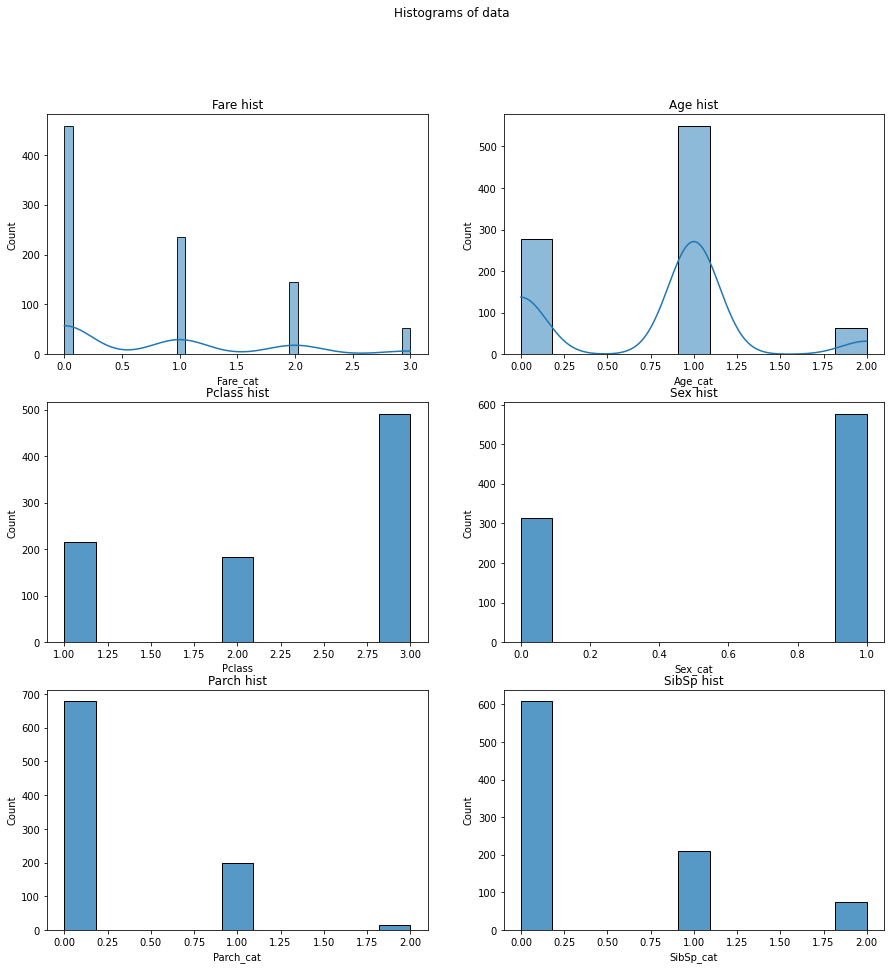

In [56]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Histograms of data')

sns.histplot(ax=axes[0][0], data=converted_df, x="Fare_cat", kde=True)
axes[0][0].set_title("Fare hist")

sns.histplot(ax=axes[0][1], data=converted_df, x="Age_cat", kde=True)
axes[0][1].set_title("Age hist")

sns.histplot(ax=axes[1][0], data=converted_df, x="Pclass")
axes[1][0].set_title("Pclass hist")

sns.histplot(ax=axes[1][1], data=converted_df, x="Sex_cat")
axes[1][1].set_title("Sex hist")

sns.histplot(ax=axes[2][0], data=converted_df, x="Parch_cat")
axes[2][0].set_title("Parch hist")

sns.histplot(ax=axes[2][1], data=converted_df, x="SibSp_cat")
axes[2][1].set_title("SibSp hist")

Итак, благодаря категоризации и визуализации данных, можно отметить:
* большая часть пассажиров заплатила до 35 у.е. за билет;
* пассажиров, не достигших 25, примерно в три раза больше, чем тех, кому за 50, при этом большей части все-таки от 25 до 50 лет;
* количество пассажиров третьего класса в сумме равно количесву пассажиров 1ого и 2ого;
* мужчин примерно вдвое больше, чем женщин;
* большинство путешествовало без детей и родителей, у какой-то части пассажиров было 1-2 компаньона;
* также большинство путешествовало без супругов и братьев-сестер, за исключением части пассажиров, у которых были компаньоны;


## Зависимость признаков и выживания

Так же важно отметить, какие признаки сильнее влияли на то, выживет ли пассажир.

Text(0.5, 1.0, 'SibSp hist')

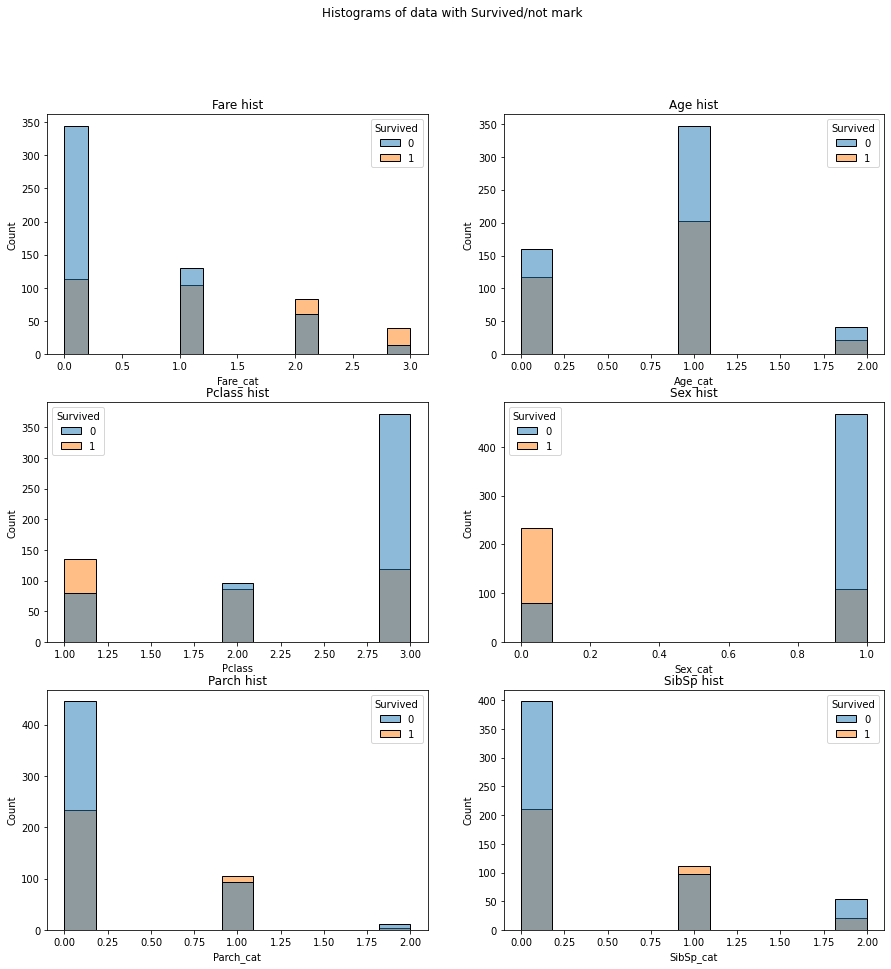

In [61]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Histograms of data with Survived/not mark')

sns.histplot(ax=axes[0][0], data=converted_df, x="Fare_cat", hue="Survived")
axes[0][0].set_title("Fare hist")

sns.histplot(ax=axes[0][1], data=converted_df, x="Age_cat", hue="Survived")
axes[0][1].set_title("Age hist")

sns.histplot(ax=axes[1][0], data=converted_df, x="Pclass", hue="Survived")
axes[1][0].set_title("Pclass hist")

sns.histplot(ax=axes[1][1], data=converted_df, x="Sex_cat", hue="Survived")
axes[1][1].set_title("Sex hist")

sns.histplot(ax=axes[2][0], data=converted_df, x="Parch_cat", hue="Survived")
axes[2][0].set_title("Parch hist")

sns.histplot(ax=axes[2][1], data=converted_df, x="SibSp_cat", hue="Survived")
axes[2][1].set_title("SibSp hist")

In [147]:
def gender_live(df):
    df_gender_surv = df.groupby(['Survived', 'Sex_cat']).size()
    df_gender_surv = df_gender_surv.reset_index(name='count')
    male_survived = df_gender_surv.loc[(df_gender_surv['Survived'] == 1) & \
                                       (df_gender_surv['Sex_cat'] == 1)]['count'].values[0]
    female_survived = df_gender_surv.loc[(df_gender_surv['Survived'] == 1) & \
                                         (df_gender_surv['Sex_cat'] == 0)]['count'].values[0]
    n_men = sum(df_gender_surv.loc[df_gender_surv['Sex_cat'] == 1]['count'])
    n_women = sum(df_gender_surv.loc[df_gender_surv['Sex_cat'] == 0]['count'])
    percent_men_surv = male_survived / n_men # сколько мужчин выжило среди всех мужчин
    percent_women_surv = female_survived / n_women # сколько женщин выжило среди всех женщин
    n_survived = sum(df_gender_surv.loc[df_gender_surv['Survived'] == 1]['count'])
    # каков процент мужчин и женщин среди всех выживших
    percent_men_surv_all, percent_women_surv_all = male_survived/n_survived, female_survived/n_survived
    return percent_men_surv, percent_women_surv, percent_men_surv_all, percent_women_surv_all

def pclass_live(df):
    df_pclass_surv = df.groupby(['Survived', 'Pclass']).size()
    df_pclass_surv = df_pclass_surv.reset_index(name='count')
    pclass1_survived = df_pclass_surv.loc[(df_pclass_surv['Survived'] == 1) & \
                                          (df_pclass_surv['Pclass'] == 1)]['count'].values[0]
    pclass2_survived = df_pclass_surv.loc[(df_pclass_surv['Survived'] == 1) & \
                                          (df_pclass_surv['Pclass'] == 2)]['count'].values[0]
    pclass3_survived = df_pclass_surv.loc[(df_pclass_surv['Survived'] == 1) & \
                                          (df_pclass_surv['Pclass'] == 3)]['count'].values[0]
    n_pclass1 = sum(df_pclass_surv.loc[df_pclass_surv['Pclass'] == 1]['count'])
    n_pclass2 = sum(df_pclass_surv.loc[df_pclass_surv['Pclass'] == 2]['count'])
    n_pclass3 = sum(df_pclass_surv.loc[df_pclass_surv['Pclass'] == 3]['count'])
    percent_pclass1_surv = pclass1_survived / n_pclass1 # сколько pclass1 выжило среди всех pclass1
    percent_pclass2_surv = pclass2_survived / n_pclass2 # сколько pclass2 выжило среди всех pclass2
    percent_pclass3_surv = pclass3_survived / n_pclass3 # сколько pclass3 выжило среди всех pclass3
    n_survived = sum(df_pclass_surv.loc[df_pclass_surv['Survived'] == 1]['count'])
    # каков процент среди всех выживших
    percent_pclass1_surv_all, percent_pclass2_surv_all, percent_pclass3_surv_all =\
    pclass1_survived/n_survived, pclass2_survived/n_survived, pclass3_survived/n_survived
    return percent_pclass1_surv, percent_pclass2_surv, percent_pclass3_surv, percent_pclass1_surv_all,\
percent_pclass2_surv_all, percent_pclass3_surv_all

def fare_live(df):
    df_fare_surv = df.groupby(['Survived', 'Fare_cat']).size()
    df_fare_surv = df_fare_surv.reset_index(name='count')
    poor_survived = df_fare_surv.loc[(df_fare_surv['Survived']==1) & \
                                     (df_fare_surv['Fare_cat'] == 0)]['count'].values[0]
    middle_survived = df_fare_surv.loc[(df_fare_surv['Survived']==1) & \
                                       (df_fare_surv['Fare_cat'] == 1)]['count'].values[0]
    rich_survived = df_fare_surv.loc[(df_fare_surv['Survived']==1) & \
                                     (df_fare_surv['Fare_cat'] == 2)]['count'].values[0]
    megarich_survived = df_fare_surv.loc[(df_fare_surv['Survived']==1) & \
                                         (df_fare_surv['Fare_cat'] == 3)]['count'].values[0]
    n_poor = sum(df_fare_surv.loc[df_fare_surv['Fare_cat'] == 0]['count'])
    n_middle = sum(df_fare_surv.loc[df_fare_surv['Fare_cat'] == 1]['count'])
    n_rich = sum(df_fare_surv.loc[df_fare_surv['Fare_cat'] == 2]['count'])
    n_megarich = sum(df_fare_surv.loc[df_fare_surv['Fare_cat'] == 3]['count'])
    percent_poor_surv = poor_survived / n_poor # сколько poor выжило среди всех poor
    percent_middle_surv = middle_survived / n_middle # сколько middle выжило среди всех middle
    percent_rich_surv = rich_survived / n_rich # сколько rich выжило среди всех rich
    percent_megarich_surv = megarich_survived / n_megarich # сколько megarich выжило среди всех megarich
    n_survived = sum(df_fare_surv.loc[df_fare_surv['Survived'] == 1]['count'])
    # каков процент среди всех выживших
    percent_poor_surv_all, percent_middle_surv_all, percent_rich_surv_all, percent_megarich_surv = \
    poor_survived/n_survived,middle_survived/n_survived, rich_survived/n_survived, megarich_survived/n_survived
    return percent_poor_surv, percent_middle_surv, percent_rich_surv, percent_megarich_surv, \
percent_poor_surv_all, percent_middle_surv_all, percent_rich_surv_all, percent_megarich_surv

def age_live(df):
    df_age_surv = df.groupby(['Survived', 'Age_cat']).size()
    df_age_surv = df_age_surv.reset_index(name='count')
    young_survived = df_age_surv.loc[(df_age_surv['Survived']==1) & (df_age_surv['Age_cat'] == 0)]['count'].values[0]
    middle_survived = df_age_surv.loc[(df_age_surv['Survived']==1) & (df_age_surv['Age_cat'] == 1)]['count'].values[0]
    ageing_survived = df_age_surv.loc[(df_age_surv['Survived']==1) & (df_age_surv['Age_cat'] == 2)]['count'].values[0]
    n_young = sum(df_age_surv.loc[df_age_surv['Age_cat'] == 0]['count'])
    n_middle = sum(df_age_surv.loc[df_age_surv['Age_cat'] == 1]['count'])
    n_ageing = sum(df_age_surv.loc[df_age_surv['Age_cat'] == 2]['count'])
    percent_young_surv = young_survived / n_young
    percent_middle_surv = middle_survived / n_middle
    percent_ageing_surv = ageing_survived / n_ageing
    n_survived = sum(df_age_surv.loc[df_age_surv['Survived'] == 1]['count'])
    # каков процент среди всех выживших
    percent_young_surv_all, percent_middle_surv_all, percent_ageing_surv_all = \
    young_survived/n_survived,middle_survived/n_survived, ageing_survived/n_survived
    return percent_young_surv, percent_middle_surv, percent_ageing_surv, percent_young_surv_all, \
percent_middle_surv_all, percent_ageing_surv

def parch_live(df):
    df_parch_surv = df.groupby(['Survived', 'Parch_cat']).size()
    df_parch_surv = df_parch_surv.reset_index(name='count')
    survived_1 = df_parch_surv.loc[(df_parch_surv['Survived']==1) & \
                                   (df_parch_surv['Parch_cat'] == 0)]['count'].values[0]
    survived_2 = df_parch_surv.loc[(df_parch_surv['Survived']==1) & \
                                   (df_parch_surv['Parch_cat'] == 1)]['count'].values[0]
    survived_3 = df_parch_surv.loc[(df_parch_surv['Survived']==1) & \
                                   (df_parch_surv['Parch_cat'] == 2)]['count'].values[0]
    n_1 = sum(df_parch_surv.loc[df_parch_surv['Parch_cat'] == 0]['count'])
    n_2 = sum(df_parch_surv.loc[df_parch_surv['Parch_cat'] == 1]['count'])
    n_3 = sum(df_parch_surv.loc[df_parch_surv['Parch_cat'] == 2]['count'])
    percent_1_surv_parch = survived_1 / n_1
    percent_2_surv_parch = survived_2 / n_2
    percent_3_surv_parch = survived_3 / n_3
    n_survived = sum(df_parch_surv.loc[df_parch_surv['Survived'] == 1]['count'])
    # каков процент среди всех выживших
    percent_1_surv_parch_all, percent_2_surv_parch_all, percent_3_surv_parch_all = \
    survived_1/n_survived, survived_2/n_survived, survived_3/n_survived
    return percent_1_surv_parch, percent_2_surv_parch, percent_3_surv_parch, \
percent_1_surv_parch_all, percent_2_surv_parch_all, percent_3_surv_parch_all

def sibsp_live(df):
    df_sibsp_surv = df.groupby(['Survived', 'SibSp_cat']).size()
    df_sibsp_surv = df_sibsp_surv.reset_index(name='count')
    survived_1 = df_sibsp_surv.loc[(df_sibsp_surv['Survived']==1) & \
                                   (df_sibsp_surv['SibSp_cat'] == 0)]['count'].values[0]
    survived_2 = df_sibsp_surv.loc[(df_sibsp_surv['Survived']==1) & \
                                   (df_sibsp_surv['SibSp_cat'] == 1)]['count'].values[0]
    survived_3 = df_sibsp_surv.loc[(df_sibsp_surv['Survived']==1) & \
                                   (df_sibsp_surv['SibSp_cat'] == 2)]['count'].values[0]
    n_1 = sum(df_sibsp_surv.loc[df_sibsp_surv['SibSp_cat'] == 0]['count'])
    n_2 = sum(df_sibsp_surv.loc[df_sibsp_surv['SibSp_cat'] == 1]['count'])
    n_3 = sum(df_sibsp_surv.loc[df_sibsp_surv['SibSp_cat'] == 2]['count'])
    percent_1_surv_sibsp = survived_1 / n_1
    percent_2_surv_sibsp = survived_2 / n_2
    percent_3_surv_sibsp = survived_3 / n_3
    n_survived = sum(df_sibsp_surv.loc[df_sibsp_surv['Survived'] == 1]['count'])
    # каков процент среди всех выживших
    percent_1_surv_sibsp_all, percent_2_surv_sibsp_all, percent_3_surv_sibsp_all = \
    survived_1/n_survived, survived_2/n_survived, survived_3/n_survived
    return percent_1_surv_sibsp, percent_2_surv_sibsp, percent_3_surv_sibsp, \
percent_1_surv_sibsp_all, percent_2_surv_sibsp_all, percent_3_surv_sibsp_all

In [162]:
percent_men_surv, percent_women_surv, percent_men_surv_all, percent_women_surv_all = gender_live(converted_df)
percent_pclass1_surv, percent_pclass2_surv, percent_pclass3_surv, percent_pclass1_surv_all,\
percent_pclass2_surv_all, percent_pclass3_surv_all = pclass_live(converted_df)
percent_poor_surv, percent_middle_surv, percent_rich_surv, percent_megarich_surv,\
percent_poor_surv_all, percent_middle_surv_all, percent_rich_surv_all, percent_megarich_surv = fare_live(converted_df)
percent_young_surv, percent_middle_surv, percent_ageing_surv, percent_young_surv_all, \
percent_middle_surv_all, percent_ageing_surv = age_live(converted_df)
percent_1_surv_parch, percent_2_surv_parch, percent_3_surv_parch, percent_1_surv_parch_all,\
percent_2_surv_parch_all, percent_3_surv_parch_all = parch_live(converted_df)
percent_1_surv_sibsp, percent_2_surv_sibsp, percent_3_surv_sibsp, percent_1_surv_sibsp_all, \
percent_2_surv_sibsp_all, percent_3_surv_sibsp_all = sibsp_live(converted_df)

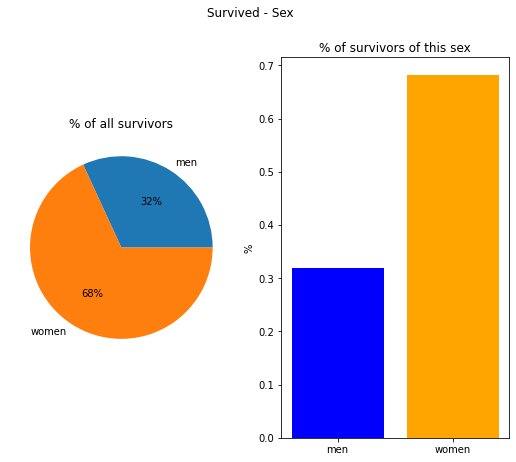

In [157]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(9,7))
fig.suptitle("Survived - Sex")
ax1.pie(list((percent_men_surv_all, percent_women_surv_all)), labels=['men', 'women'], autopct='%.0f%%')
ax2.bar(['men', 'women'], list((percent_men_surv_all, percent_women_surv_all)), color=['blue', 'orange'])
ax2.set_ylabel('%')
ax1.set(title='% of all survivors')
ax2.set(title='% of survivors of this sex')
plt.show()

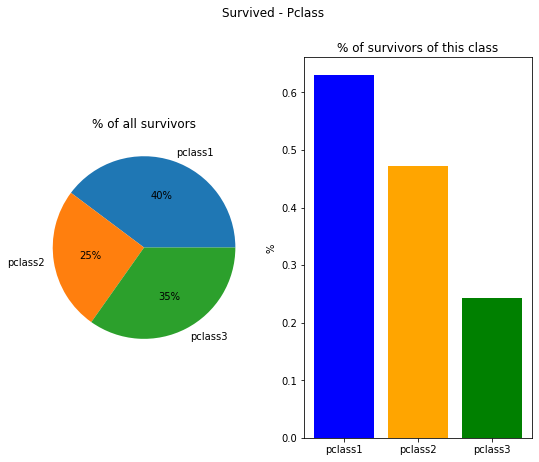

In [158]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(9,7))
fig.suptitle("Survived - Pclass")
ax1.pie(list((percent_pclass1_surv_all, percent_pclass2_surv_all, percent_pclass3_surv_all)), \
        labels=['pclass1', 'pclass2', 'pclass3'], autopct='%.0f%%')
ax2.bar(['pclass1', 'pclass2', 'pclass3'], list((percent_pclass1_surv, percent_pclass2_surv, percent_pclass3_surv)),\
        color=['blue', 'orange', 'green'])
ax2.set_ylabel('%')
ax1.set(title='% of all survivors')
ax2.set(title='% of survivors of this class')
plt.show()

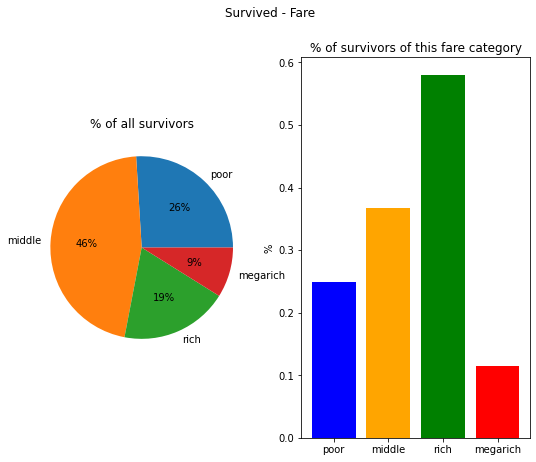

In [159]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(9,7))
fig.suptitle("Survived - Fare")
ax1.pie(list((percent_poor_surv_all, percent_middle_surv_all, percent_rich_surv_all, percent_megarich_surv)), \
        labels=['poor', 'middle', 'rich', 'megarich'], autopct='%.0f%%')
ax2.bar(['poor', 'middle', 'rich', 'megarich'], list((percent_poor_surv, percent_middle_surv, percent_rich_surv, \
                                                      percent_megarich_surv)), color=['blue', 'orange', 'green', 'red'])
ax2.set_ylabel('%')
ax1.set(title='% of all survivors')
ax2.set(title='% of survivors of this fare category')
plt.show()

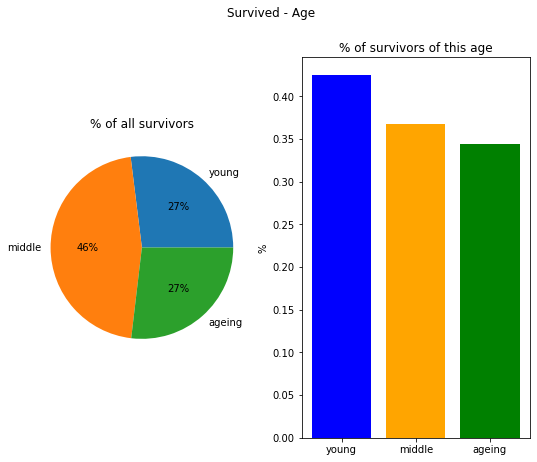

In [160]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(9,7))
fig.suptitle("Survived - Age")
ax1.pie(list((percent_young_surv_all, percent_middle_surv_all, percent_ageing_surv)), \
        labels=['young', 'middle', 'ageing'], autopct='%.0f%%')
ax2.bar(['young', 'middle', 'ageing'], list((percent_young_surv, percent_middle_surv, percent_ageing_surv)),\
        color=['blue', 'orange', 'green'])
ax2.set_ylabel('%')
ax1.set(title='% of all survivors')
ax2.set(title='% of survivors of this age')
plt.show()

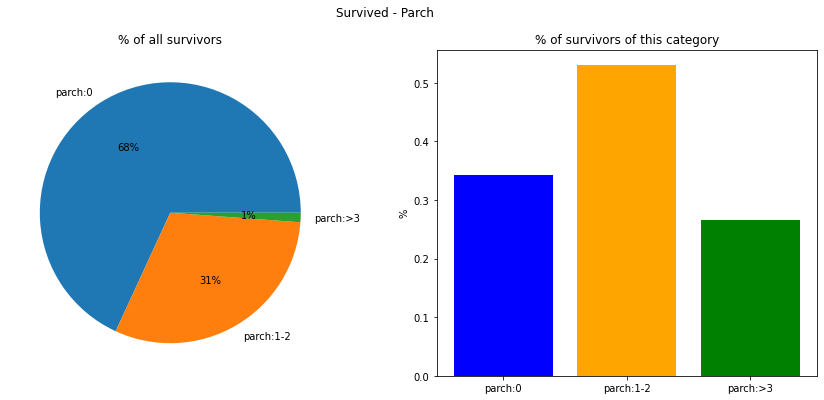

In [155]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
fig.suptitle("Survived - Parch")
ax1.pie(list((percent_1_surv_parch_all, percent_2_surv_parch_all, percent_3_surv_parch_all)),\
        labels=['parch:0', 'parch:1-2', 'parch:>3'], autopct='%.0f%%')
ax2.bar(['parch:0', 'parch:1-2', 'parch:>3'], list((percent_1_surv_parch, percent_2_surv_parch, percent_3_surv_parch)),\
        color=['blue', 'orange', 'green'])
ax2.set_ylabel('%')
ax1.set(title='% of all survivors')
ax2.set(title='% of survivors of this category')
plt.show()

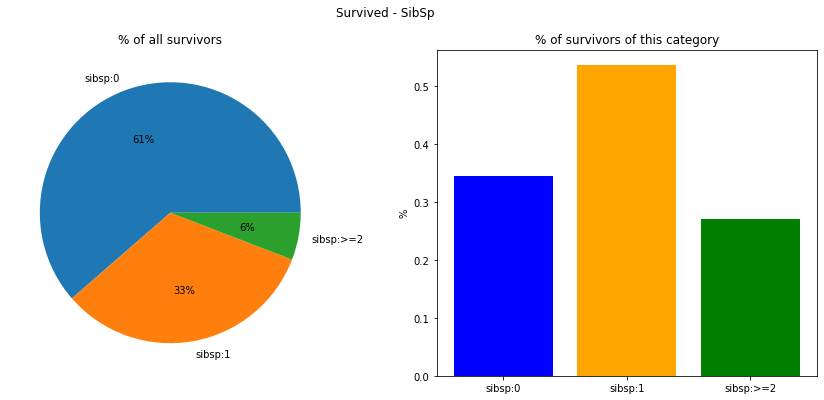

In [161]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
fig.suptitle("Survived - SibSp")
ax1.pie(list((percent_1_surv_sibsp_all, percent_2_surv_sibsp_all, percent_3_surv_sibsp_all)), \
        labels=['sibsp:0', 'sibsp:1', 'sibsp:>=2'], autopct='%.0f%%')
ax2.bar(['sibsp:0', 'sibsp:1', 'sibsp:>=2'], list((percent_1_surv_sibsp, percent_2_surv_sibsp, percent_3_surv_sibsp)),\
        color=['blue', 'orange', 'green'])
ax2.set_ylabel('%')
ax1.set(title='% of all survivors')
ax2.set(title='% of survivors of this category')
plt.show()

#### Итак, с помощью данных графиков мы продемонстрировали зависимости между фичами и целевым показателем:
* выжило примерно в два раза больше женщин, чем мужчин;
* выжило порядка 60% 1ого класса, но всего лишь порядка 25% 3его, почти аналогичные результаты в разбиении "богатые-бедные", средний класс находится посередине в обеих категориях;
* а вот возраст не оказался решающим фактором для выживания: показатели трех групп весьма схожи;
* что интересно, чаще выживали люди с одним компаньоном (или родственником), чем вообще без них или более, чем с двумя компаньонами;

Получается, что все вышеописанные признаки (в разной степени) играют роль в определении целевого показателя, поэтому для дальнейшей работы их нужно оставить.

#### Необходимая предобработка данных будет включать:
* замена nans на среднее значение категории
* категоризация признаков Fare, Age, SibSp, Parch
* замена группы выбросов в Fare на медиану этой группы 
* scaling признаков Fare, Age
* one-hot-encoding для признаков Pclass и Sex, т.к. для них отсутствует отношение в смысле "больше-меньше"
* отбор фичей в датасет-результат: категоризированные Fare, Age, SibSp, Parch; one-hot-encoding для признаков Pclass и Sex; scaling признаков Fare, Age; целевой Survived

# Часть 2: результаты работы

### В работе будут использованы различные методы классификации, основанные на методе обучения с учителем:
#### DecisionTreeClassifier - дерево решений
Используемые гиперпараметры:
* criterion='gini' - этот критерий делает подход выделения класса в листе стохастическим и ответ для точки выдается с вероятностью, заданной каждым классом
* ccp_alpha=optimal_alpha - используется подход pruning для пресечения переобучения, с помощью отдельной функции, основанной на подходе кросс-валидации подбираем оптимальный параметр альфа (есть в коде)
* max_depth=10 - ограничиваем глубину дерева

#### KNeighborsClassifier - метод k ближайших соседей
Используемые гиперпараметры:
* n_neighbors=optimal_k - с помощью кросс-валидации подбираем оптимальное число соседей в заданном интервале
* algorithm='kd_tree' - используем алгоритм построение k-dimensional tree для ускорения решения и более осмысленного поиска среди ограниченного количества соседей в ячейке
* weights='distance' - используем взвешенный алгоритм

#### LinearSVC - линейный метод опорных векторов

#### AdaBoostClassifier и GradientBoostingClassifier - адаптивный и градиентный бустинг - использует информацию с предыдущих шагов, каждым новым пытаясь улучшить результат
Используемые гиперпараметры:
* n_estimators=optimal_n_estimators - с помощью кросс-валидации подбираем оптимальное число для каждого бустинга отдельно

### Ансамбли: комбинации различных алгоритмов, два вида голосования: hard (по количеству голосов) и soft (с учетом степени уверенности)
#### ensemble_dtree_knn_soft - использует DecisionTreeClassifier и KNeighborsClassifier, тип голосования: soft

#### ensemble_dtree_knn_svc_hard - использует DecisionTreeClassifier,  LinearSVC и KNeighborsClassifier, тип голосования: hard

#### ensemble_boosters_soft - использует AdaBoostClassifier и GradientBoostingClassifier, тип голосования: soft

#### ensemble_all_soft - DecisionTreeClassifier, KNeighborsClassifier, AdaBoostClassifier и GradientBoostingClassifier, тип голосования: soft

#### ensemble_all_hard - DecisionTreeClassifier,  LinearSVC, KNeighborsClassifier, AdaBoostClassifier и GradientBoostingClassifier, тип голосования: hard


## Сравнение классификаторов:

In [21]:
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier


def read_data(path_input):
    """
    :param path_input: путь до файла
    :return: датафрейм
    """
    df = pd.read_csv(path_input)
    return df


def collect_data(df):
    """
    Делит данные на выборки.
    :param df: датафрейм
    :return: словарь с train, val, test выборками
    """
    X = df.drop(columns=['Survived'])
    y = df['Survived']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)
    df_dict = {
        'train': (X_train, y_train),
        'val': (X_val, y_val),
        'test': (X_test, y_test)
    }
    return df_dict


def tree_get_params(df_dict, metric, build_graph=False):
    """
    Термины:
        pruning - обрезать лишние ветки с итогового дерева, чтобы убрать возможное переобучение
        alpha - штраф за каждый добавленный лист
        Error = [error] + alpha*[tree_size]
    Ищет оптимальное значение alpha, при котором увеличилось accuracy

    :param df_dict: словарь с train, val, test выборками
    :param metric: метрика
    :param build_graph: логическое значение: строить ли график
    :return: ccp_alpha параметр для построения дерева
    """
    X_train, y_train = df_dict['train']
    X_val, y_val = df_dict['val']

    clf = DecisionTreeClassifier()
    path = clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities

    clfs = []
    for ccp_alpha in ccp_alphas:
        clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
        clf.fit(X_train, y_train)
        clfs.append(clf)

    scores = [metric(y_val, clf.predict(X_val)) for clf in clfs]
    max_score_ix = scores.index(max(scores))
    optimal_alpha = ccp_alphas[max_score_ix]

    if build_graph:
        plt.figure(figsize=(10, 6))
        plt.grid()
        plt.plot(ccp_alphas[:-1], scores[:-1])
        plt.xlabel("Effective alpha for DecisionTree")
        plt.ylabel(f"{metric.__name__}")
        plt.show()

    return optimal_alpha


def choose_best_k(df_dict, n, metric, build_graph=False):
    """
    :param df_dict: словарь с train, val, test выборками
    :param n: максимальное количество возможных соседей
    :param metric: метрика
    :param build_graph: логическое значение: строить ли график
    :return: оптимальное k и график
    """
    X_train, y_train = df_dict['train']
    X_val, y_val = df_dict['val']
    X = pd.concat([X_train, X_val], ignore_index=True)
    y = pd.concat([y_train, y_val], ignore_index=True)

    mean_cross_val = []
    k_list = [j for j in range(1, n)]
    for k in range(1, n):
        clf = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree', weights='distance')
        cross_val_score_list = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(metric))
        mean_cross_val.append(statistics.mean(cross_val_score_list))
    max_metric_ix = mean_cross_val.index(max(mean_cross_val))
    optimal_k = k_list[max_metric_ix]

    if build_graph:
        plt.figure(figsize=(10, 6))
        plt.grid()
        plt.plot(k_list, mean_cross_val)
        plt.xlabel("Effective k for KNN")
        plt.ylabel(f"{metric.__name__}")
        plt.show()

    return optimal_k


def get_best_n_estimators_value(df_dict, metric, classifier, build_graph=False):
    """
    Выбрать оптимальное число n_estimators.
    :param classifier: классификатор
    :param metric: метрика
    :param df_dict: словарь с train, val, test выборками
    :param build_graph: логическое значение: строить ли график
    :return: параметр n_estimators, который дал лучшее значение метрики
    """
    X_train, y_train = df_dict['train']
    X_val, y_val = df_dict['val']

    metric_list = []
    n_of_estimators_list = []
    for n in range(25, 300, 25):
        clf = classifier(n_estimators=n)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        metric_value = metric(y_val, y_pred)
        metric_list.append(metric_value)
        n_of_estimators_list.append(n)
    max_metric_value = max(metric_list)
    best_n_estimators_value = n_of_estimators_list[metric_list.index(max_metric_value)]

    if build_graph:
        plt.figure(figsize=(10, 6))
        plt.grid()
        plt.plot(n_of_estimators_list, metric_list)
        plt.xlabel(f"Effective n_of_estimators for {classifier.__name__}")
        plt.ylabel(f"{metric.__name__}")
        plt.show()

    return best_n_estimators_value


def compare_classifier(df_dict, metric=roc_auc_score, max_n=30):
    """
    Сравнить классификаторы и вариации их ансамбля для разных типов голосования на test выборке.
    :param df_dict: словарь с train, val, test выборками
    :param metric: метрика
    :param max_n: максимальное количество возможных соседей для Knn
    :return: результаты классификаторов и их ансамбля
    """
    X_train, y_train = df_dict['train']
    X_test, y_test = df_dict['test']

    optimal_alpha = tree_get_params(df_dict, metric, build_graph=False)
    clf_DS = DecisionTreeClassifier(criterion='gini', ccp_alpha=optimal_alpha, max_depth=10)
    clf_DS.fit(X_train, y_train)
    y_pred_DS = clf_DS.predict(X_test)

    optimal_k = choose_best_k(df_dict, max_n, metric, build_graph=False)
    clf_KNN = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree', weights='distance')
    clf_KNN.fit(X_train, y_train)
    y_pred_KNN = clf_KNN.predict(X_test)

    clf_SVC = LinearSVC()
    clf_SVC.fit(X_train, y_train)
    y_pred_SVC = clf_SVC.predict(X_test)

    n_estimators_adaboost = get_best_n_estimators_value(df_dict, metric, AdaBoostClassifier, build_graph=False)
    clf_ADABOOST = AdaBoostClassifier(n_estimators=n_estimators_adaboost)
    clf_ADABOOST.fit(X_train, y_train)
    y_pred_ADABOOST = clf_ADABOOST.predict(X_test)

    n_estimators_gradientboost = get_best_n_estimators_value(df_dict, metric, GradientBoostingClassifier,
                                                            build_graph=False)
    clf_GRADIENTBOOST = GradientBoostingClassifier(n_estimators=n_estimators_gradientboost)
    clf_GRADIENTBOOST.fit(X_train, y_train)
    y_pred_GRADIENTBOOST = clf_GRADIENTBOOST.predict(X_test)

    ensemble_dtree_knn_soft = VotingClassifier(estimators=[('dtree', clf_DS), ('knn', clf_KNN)], voting='soft')
    ensemble_dtree_knn_soft.fit(X_train, y_train)
    y_pred_ensemble_dtree_knn_soft = ensemble_dtree_knn_soft.predict(X_test)

    ensemble_dtree_knn_svc_hard = VotingClassifier(estimators=[('dtree', clf_DS), ('knn', clf_KNN), ('svc', clf_SVC)],
                                                   voting='hard')
    ensemble_dtree_knn_svc_hard.fit(X_train, y_train)
    y_pred_ensemble_dtree_knn_svc_hard = ensemble_dtree_knn_svc_hard.predict(X_test)

    ensemble_boosters_soft = VotingClassifier(
        estimators=[('adaboost', clf_ADABOOST), ('gradientboost', clf_GRADIENTBOOST)], voting='soft')
    ensemble_boosters_soft.fit(X_train, y_train)
    y_pred_ensemble_boosters_soft = ensemble_boosters_soft.predict(X_test)

    ensemble_all_soft = VotingClassifier(
        estimators=[('dtree', clf_DS), ('knn', clf_KNN), ('adaboost', clf_ADABOOST),
                    ('gradientboost', clf_GRADIENTBOOST)],
        voting='soft')
    ensemble_all_soft.fit(X_train, y_train)
    y_pred_ensemble_all_soft = ensemble_all_soft.predict(X_test)

    ensemble_all_hard = VotingClassifier(
        estimators=[('dtree', clf_DS), ('knn', clf_KNN), ('svc', clf_SVC), ('adaboost', clf_ADABOOST),
                    ('gradientboost', clf_GRADIENTBOOST)],
        voting='hard')
    ensemble_all_hard.fit(X_train, y_train)
    y_pred_ensemble_all_hard = ensemble_all_hard.predict(X_test)

    scores_dict = {}
    estimators_predictions = [y_pred_DS, y_pred_KNN, y_pred_SVC, y_pred_ADABOOST, y_pred_GRADIENTBOOST,
                              y_pred_ensemble_dtree_knn_soft, y_pred_ensemble_dtree_knn_svc_hard,
                              y_pred_ensemble_boosters_soft, y_pred_ensemble_all_hard, y_pred_ensemble_all_soft]
    estimators_names = ['DecisionTreeClassifier', 'KNeighborsClassifier', 'LinearSVC', 'AdaBoost', 'GradientBoost',
                           'Ensemble_dtree_knn_soft', 'Ensemble_dtree_knn_svc_hard',
                           'Ensemble_boosters_soft', 'Ensemble_all_hard', 'Ensemble_all_soft']
    for y_pred, label in zip(estimators_predictions, estimators_names):
        score = metric(y_test, y_pred)
        scores_dict[label] = score

    return scores_dict

dirname = os.path.abspath('')
filename = os.path.join(dirname, r'.\data\prepared_train.csv')
df = read_data(filename)
df_dict = collect_data(df)
scores_dict_acc = compare_classifier(df_dict, metric=accuracy_score, max_n=30)
scores_dict_roc_auc = compare_classifier(df_dict, metric=roc_auc_score, max_n=30)

C:\Users\pavlu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\pavlu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\pavlu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\pavlu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed t

In [19]:
def build_bar_plot(scores_dict, metric):
    fig = plt.figure(figsize=(12,8))
    names = list(scores_dict.keys())
    values = list(scores_dict.values())
    plt.bar(range(len(scores_dict)), values, tick_label=names)
    plt.title(f'Comparison of classifiers with {metric.__name__}')
    plt.xticks(range(len(scores_dict)), names, rotation=90)
    plt.xlabel("Classifiers")
    plt.ylabel(metric.__name__)
    plt.show()
    
def get_best_classifier(scores_dict, metric):
    estimators_names = list(scores_dict.keys())
    scores = list(scores_dict.values())
    max_score = max(scores)
    best_clf_name = estimators_names[scores.index(max_score)]
    return best_clf_name, max_score

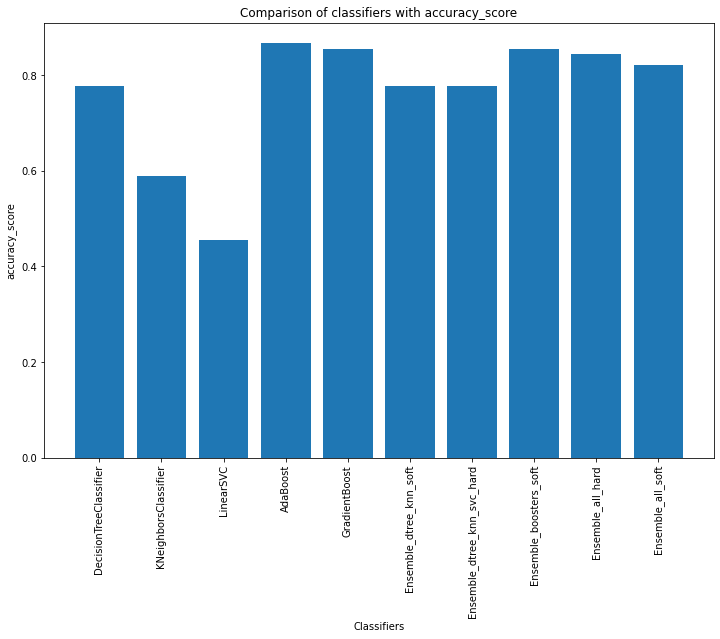

In [26]:
build_bar_plot(scores_dict_acc, accuracy_score)

In [27]:
best_clf_name, max_score = get_best_classifier(scores_dict_acc, accuracy_score)
best_clf_name, max_score

('AdaBoost', 0.8666666666666667)

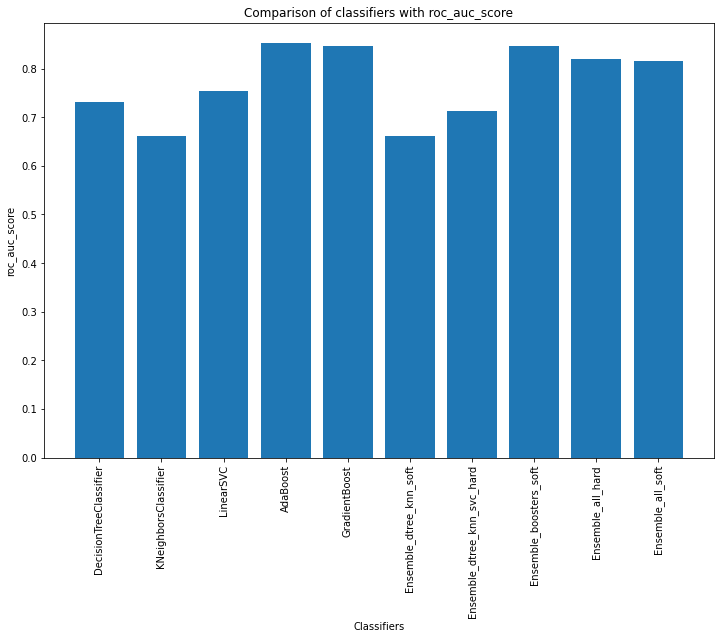

In [28]:
build_bar_plot(scores_dict_roc_auc, roc_auc_score)

In [29]:
best_clf_name, max_score = get_best_classifier(scores_dict_roc_auc, roc_auc_score)
best_clf_name, max_score

('AdaBoost', 0.8518518518518517)

В результате нескольких повторений экспериментов и анализа графиков, можно отметить, что отличный результат показывают:
* бустеры и их комбинация
* ансамбли всех классификаторов с обоими типами голосования

Сформируем ответы для этих вариантов и проверим, какие результаты будут на тестовой выборке.

In [32]:
result_dict = {'adaboost': 0.75358, 'gradientboost': 0.78468, 'ensemble_boosters_soft': 0.78468, \
               'ensemble_all_soft': 0.79186, 'ensemble_all_hard': 0.78229}

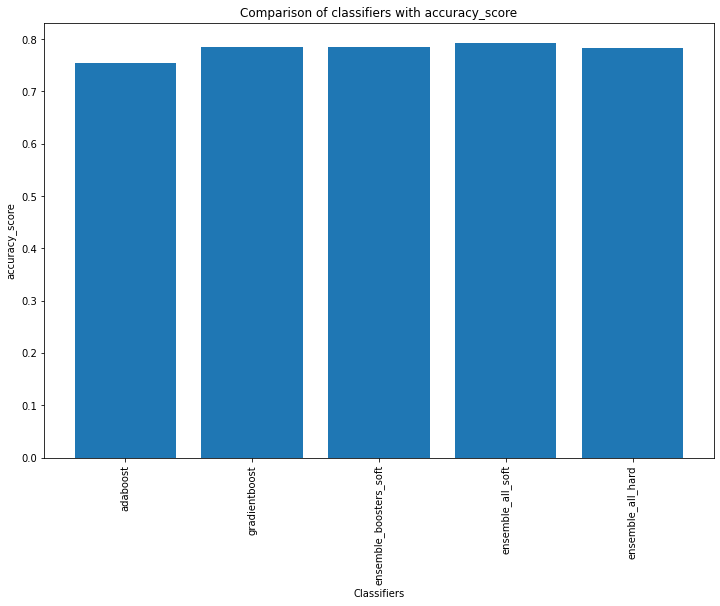

In [31]:
build_bar_plot(result_dict, accuracy_score)

In [33]:
best_clf_name, max_score = get_best_classifier(result_dict, accuracy_score)
best_clf_name, max_score

('ensemble_all_soft', 0.79186)

### Итак, достигнутый результат на тестовой выборке - 0.79186, лучшим оказался ансамбль с soft голосованием, но все модели в итоге показали себя практически одинаково до сотых. 

Подводя итог:
* получилось выявить важные признаки в данных, влиящие на целевую переменную
* благодаря анализу данных, сформировался пайплайн их обработки
* при анализе классификаторов были выявлены лидеры и на них далее производился prediction
* благодаря визуализации, получилось оценить все результаты наглядно